# Binary Classification

In [1]:
import toml
import pandas as pd

from app.cleaning import LabelCleaner
from app.imaging import ImageHandler
from app.model import ModelController, ModelParameters, ModelPreparation, ModelPredictor
from app.utils import load_model
from app.plotter import plot_cm, plot_losses, plot_model_preds

In [2]:
all_params = toml.load("parameters.toml")

label_params = all_params['labelparameters']
model_params_dict = {key.lower(): val for key, val in all_params['modelparameters'].items()}

In [3]:
print(label_params)
print(model_params_dict)

{'LABEL_CLASSES': ['civilian', 'military'], 'LABEL_COLUMNS': ['filename', 'class', 'type']}
{'epochs': 1000, 'learning_rate': 0.001, 'batch_size': 128, 'hidden_layer_sizes': [512, 256], 'num_classes': 2, 'seed': 386}


## Label Pre-Processing

In [4]:
train_labels = pd.read_csv('labels/train_labels.csv', sep=',')
test_labels = pd.read_csv('labels/test_labels.csv', sep=',')

In [5]:
lb = LabelCleaner(train_labels, test_labels, labels=label_params['LABEL_CLASSES'])
data_labels = lb.clean_data()

train_labels overlap duplicates removed: 75
test_labels overlap duplicates removed: 6


In [6]:
data_labels = data_labels[label_params['LABEL_COLUMNS']]

## Update Image Names & Location

In [7]:
img_handler = ImageHandler(data_labels, class_labels=label_params['LABEL_CLASSES'])

In [8]:
img_handler.update_data_dir()

Total invalid: 148


C:\Projects\Rowden\app\imaging.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len_label_a = len(self.data_labels[filepaths.str.contains(self.labels[0])])
C:\Projects\Rowden\app\imaging.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len_label_b = len(self.data_labels[filepaths.str.contains(self.labels[1])])


Moved: 1956 imgs -> civilian directory, 4669 imgs -> military directory


In [9]:
data_labels = img_handler.data_labels
data_labels

,filename,class,type,img_filepaths
0,civilian_0.jpg,civilian,train,C:\Projects\Rowden\data\0023ae82ca0f1487c33a46...
1,civilian_1.jpg,civilian,train,C:\Projects\Rowden\data\0101020114.side.jpg
2,civilian_2.jpg,civilian,train,C:\Projects\Rowden\data\013d6ebd2b2951fb52c8dd...
3,civilian_3.jpg,civilian,train,C:\Projects\Rowden\data\0158.jpg
4,civilian_4.jpg,civilian,train,C:\Projects\Rowden\data\03-Aerolineas-Argentin...
...,...,...,...,...
6620,military_4664.jpg,military,test,C:\Projects\Rowden\data\_110072566_gettyimages...
6621,military_4665.jpg,military,test,C:\Projects\Rowden\data\_57608873_drone.jpg
6622,military_4666.jpg,military,test,C:\Projects\Rowden\data\_83539969_b47a9225-6db...
6623,military_4667.jpg,military,test,C:\Projects\Rowden\data\_90482169_a1648047-7a1...


In [10]:
train_indices = data_labels[data_labels['type'] == 'train'].index.to_list()
test_indices = data_labels[data_labels['type'] == 'test'].index.to_list()

In [11]:
model_params = ModelParameters(**model_params_dict)
model_prep = ModelPreparation(model_params)

In [12]:
train_loader, valid_loader, test_loader = model_prep.split_data(
    data_filepath='data',
    train_indices=train_indices,
    test_indices=test_indices
)

Training data: 5645
Validation data: 490
Test data: 490


## Create & Train Model

In [13]:
model_controller = ModelController(model_params=model_params, train_loader=train_loader, valid_loader=valid_loader)

In [14]:
# model = model_controller.train(epochs=model_params.epochs, save_filepath='saved_models/mobilenetv3.pt')

## Load Model & Visualise Results

In [15]:
model_params = ModelParameters(**model_params_dict)
model = load_model(model_controller.model, filepath='saved_models/mobilenetv3.pt')

In [16]:
model_predictor = ModelPredictor(model, test_data=test_loader)

In [17]:
y_pred, y_true = model_predictor.predict(seed=model_params.seed)

In [18]:
stats = model_predictor.compute_stats(y_pred, y_true)
stats

{'precision': 0.9375, 'recall': 0.9375, 'accuracy': 0.9375, 'f1_score': 0.9375}

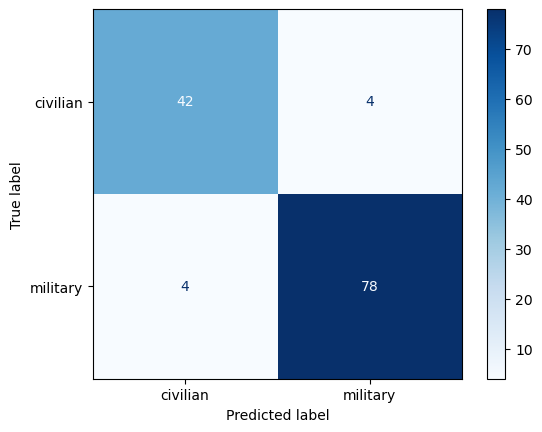

In [19]:
# | TP | FP |
# | FN | TN |
plot_cm(y_pred, y_true, label_params['LABEL_CLASSES'])

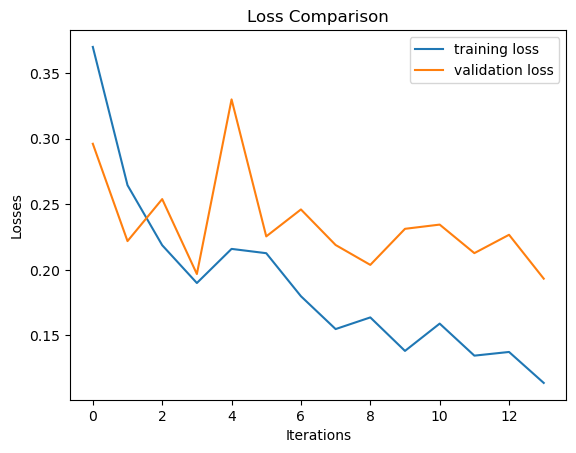

In [20]:
plot_losses(model.logger.train_loss, model.logger.valid_loss)

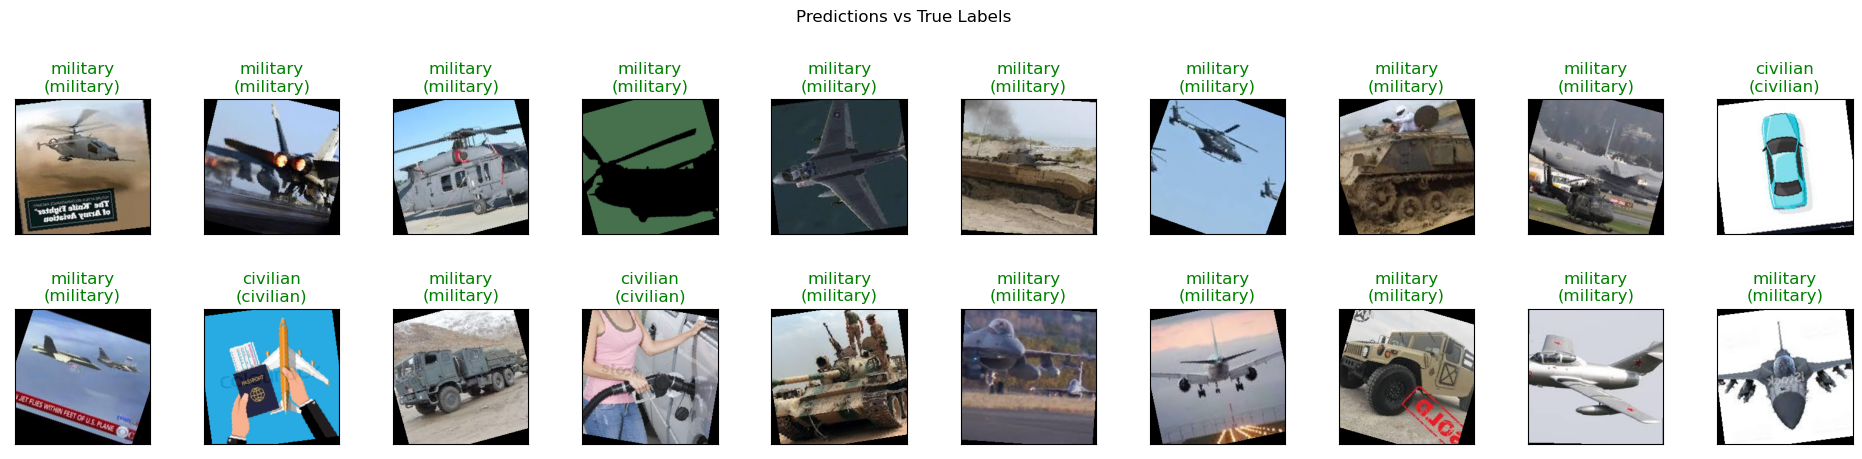

In [21]:
plot_model_preds(model, test_data=test_loader, class_labels=label_params['LABEL_CLASSES'])